In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# ! rm -rf content/NU_Radiology/

In [0]:
! git clone https://github.com/eyang9001/NU_Radiology.git
! pip install simpleitk

Cloning into 'NU_Radiology'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 102 (delta 48), reused 58 (delta 11), pack-reused 0
Receiving objects: 100% (102/102), 13.19 MiB | 32.69 MiB/s, done.
Resolving deltas: 100% (48/48), done.
     |████████████████████████████████| 42.5MB 97.8MB/s 


In [0]:
from sys import platform as sys_pf
# if sys_pf == 'darwin':
#     import matplotlib
#     matplotlib.use("TkAgg")
! pip install simpleitk
%matplotlib inline  
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import SimpleITK as sitk
from scipy import ndimage
import random
import math

mris_folder = 'NU_Radiology/mris/'
motion_folder = 'NU_Radiology/motions/'
image_shape = (256,256,176)

     |████████████████████████████████| 42.5MB 8.4MB/s 


In [0]:
class mri(object):
    def __init__(self, filename):
        self.conv_file(filename)
        self.ks = np.fft.fftn(self.original)
        self.ks = np.fft.fftshift(self.ks)
        self.max = np.amax(self.original)
        self.min = np.amin(self.original)
        self.ks_vis = np.abs(self.ks)
        self.x, self.y, self.z = self.original.shape
        self.slices = self.x
        self.rate = 1 # The number of slices that are skipped for transformations
    
    def conv_file(self, filename):
        reader = sitk.ImageFileReader()
        reader.SetImageIO("NiftiImageIO")
        reader.SetFileName(filename)
        image = reader.Execute()

        # img1 = sitk.ReadImage(folder + item)  # alternative way to pull in image

        # convert image into np array & perform fft
        img = sitk.GetArrayFromImage(image)
        # Transpose the image so the first axis is Anterior-Posterior
        img = np.transpose(img, (2,1,0))
        self.original = img 
    
    def fft_back(self, kspace):
        # Produce the image given the kspace
        back_fft = np.fft.ifftn(kspace)
        return back_fft
    
    # modifies the whole 3d kspace and then returns a specific slice
    # returns the slice of the modified kspace as well as visual representation
    def mod_kspace_slice(self, trans, rot, slice_num):
        # Rotations are passed in as [yaw, pitch, roll]
        # rotation axes of (1,2) is nodding,(0,2) is shaking, (0,1) is cracking
        mod3d = self.ks.copy()
        mod_v = self.original.copy()
        mod_r = mod3d.real
        mod_i = mod3d.imag
        
        if rot != None:
            # Yaw rotation
            mod_v = ndimage.rotate(mod_v, rot[0], (0,2), reshape = False)
            mod_r = ndimage.rotate(mod_r, rot[0], (0,2), reshape = False)
            mod_i = ndimage.rotate(mod_i, rot[0], (0,2), reshape = False)
            # Pitch rotation
            mod_v = ndimage.rotate(mod_v, rot[1], (1,2), reshape = False)
            mod_r = ndimage.rotate(mod_r, rot[1], (1,2), reshape = False)
            mod_i = ndimage.rotate(mod_i, rot[1], (1,2), reshape = False)
            # Roll rotation
            mod_v = ndimage.rotate(mod_v, rot[2], (0,1), reshape = False)
            mod_r = ndimage.rotate(mod_r, rot[2], (0,1), reshape = False)
            mod_i = ndimage.rotate(mod_i, rot[2], (0,1), reshape = False)
        if trans != None:
            mod_v = ndimage.shift(mod_v, trans, mode='constant', cval=0)
            mod_r = ndimage.shift(mod_r, trans, mode='constant', cval=0)
            mod_i = ndimage.shift(mod_i, trans, mode='constant', cval=0)
        return mod_r[slice_num] + mod_i[slice_num] *1j, mod_v[slice_num]

    # Translating a specific slice
    # Returns the slice after translation
    def translate(self, space, slice_num, value):
        if space == 'v':
            slc = self.original[slice_num]
        elif space == 'k':
            slc = self.ks_vis[slice_num]
        tran = ndimage.shift(slc,value, mode='constant', cval=0)
        return tran
    
    # Rotating a specific slice
    # Returns the slice after rotation
    def rotate(self, space, slice_num, value, axis=None):
        # If the rotation is in visual space, or k-space
        if space == 'v':
            slc = self.original[slice_num]
            rot = ndimage.rotate(slc, value, reshape = False)
        elif space == 'k':
            slc = self.ks[slice_num]
            rot = ndimage.rotate(slc, value, reshape = False, cval=0)
        return rot
    
    # Displays a slice with an original slice
    def show_slice(self, img, slice_num, space):
        if space == 'v':
            slc = self.original[slice_num]
        elif space == 'k':
            slc = self.ks_vis[slice_num]
        plt.figure(figsize= (20,20))
        plt.subplot(121), plt.imshow(slc, cmap='gray')
        plt.title('Original'), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(img, cmap='gray')
        plt.title('New'), plt.xticks([]), plt.yticks([])
        
    def create_mod_slices(self, motion):
        modded_k = []
        modded_v = []
        trans_log = []
        
        for i in np.arange(len(self.ks)):
            motion_step = int(i*motion.length/len(self.ks))
            if (i % self.rate == 0) and motion_step < motion.length :
                trans = [motion.trans_x[motion_step], motion.trans_y[motion_step], motion.trans_z[motion_step]]
                rot = [motion.yaw[motion_step], motion.pitch[motion_step], motion.roll[motion_step]]
                k, v = self.mod_kspace_slice(trans,rot,i)
                modded_k.append(k)
                modded_v.append(v)
                trans_log.append([i, motion.trans_x[motion_step], motion.trans_y[motion_step], motion.trans_z[motion_step], motion.yaw[motion_step], motion.pitch[motion_step], motion.roll[motion_step]])
                print('Slice #{} out of {} completed'.format(i, len(self.ks)))
            else:
                modded_k.append(self.ks[i])
                modded_v.append(self.original[i])
            # Here, the modded_v is only a visual representation of each slice's transformation
            # Returns transf_v as the blurred images
        transf_v = mri1.fft_back(modded_k)
        transf_v = self.transp_img(np.abs(transf_v))
        
        # transf_v will be left-right orientation while modded_v is anterior-posterior
        return transf_v, modded_v, trans_log
    
    def transp_img(self, data):
        return np.transpose(data, (2,1,0))
    
    def save_to_file(self, data, name):
        # Takes in 3d array and converts to 2d, then saves to file
        # If the file doesn't have imaginary component, set 'frm' as 'v'
        output_r=[]
        for sublist in data:
            for item in sublist:
                    output_r.append(item)
        np.savetxt(name, output_r, fmt="%s" ,delimiter=',')
    
    def show_rotations(self, data):
        plt.figure(figsize= (20,20))
        plots = []
        p_count = 0

        for i in np.arange(len(data)):
            if (i % self.rate == 0) and len(plots) < 50:
                plots.append(data[i])
                
        for i in range(10):
            for j in range(5):
                plt.subplot2grid((10,5), (i,j)), plt.imshow(plots[p_count], cmap='gray')
                p_count += 1
                if p_count == len(plots):
                    break
            if p_count == len(plots):
                break

class motion(object):
    def __init__(self, filename):
        trans_scale = 1
        self.filename = filename
        self.raw = np.loadtxt(filename)
        self.length = len(self.raw)
        self.yaw = []
        self.pitch=[]
        self.roll=[]
        self.trans_x = []
        self.trans_y = []
        self.trans_z = []
        for i in range(len(self.raw)):
            self.yaw.append(self.raw[i][0]*180/math.pi)
            self.pitch.append(self.raw[i][1]*180/math.pi)
            self.roll.append(self.raw[i][2]*180/math.pi)
            # Still need to figure out the conversion of translations from motion file
            self.trans_x.append(self.raw[i][3]*trans_scale)
            self.trans_y.append(self.raw[i][4]*trans_scale)
            self.trans_z.append(self.raw[i][5]*trans_scale)
            
def read_file(filename):
    data = np.loadtxt(filename, delimiter=",")
    data = np.reshape(data,(176,256,256))
    return data


In [0]:
# Full pipeline

mris_folder = 'gdrive/My Drive/NU_Rad/mris/'
motion_folder = 'gdrive/My Drive/NU_Rad/motion/'
cache_folder = 'gdrive/My Drive/NU_Rad/cache/'
out_folder = 'gdrive/My Drive/NU_Rad/transforms/'


for item in os.listdir(mris_folder):
    if item.endswith(".nii"):
        mri1 = mri(mris_folder + item)
        for mot_file in os.listdir(motion_folder):
            suffix = '/' + item[:-4] + '_' + mot_file[:-4]
            motion1 = motion(motion_folder + mot_file)
            
            print('Processing mri: {}, motion: {}'.format(item,mot_file))
            transf_v, _, mod_log = mri1.create_mod_slices(motion1)
            
            np.savetxt(out_folder + suffix + '_1mod.txt', mod_log, fmt="%s" ,delimiter=',')
            print('Cache saved for mri: {}, motion: {}'.format(item,mot_file))

            mri1.save_to_file(transf_v, out_folder + suffix + '_trans_1mod.txt.gz')
            print('Modified vis saved for mri: {}, motion: {}'.format(item,mot_file))
#             os.remove(cache_folder + suffix + '_k' + '_r.txt.gz')
#             print('Cache deleted: ' + cache_folder + suffix + '_k' + '_r.txt.gz')
#             os.remove(cache_folder + suffix + '_k' + '_i.txt.gz')
#             print('Cache deleted: ' + cache_folder + suffix + '_k' + '_i.txt.gz')
            

Processing mri: M01.nii, motion: motion1.dat
Slice #0 out of 256 completed
Slice #1 out of 256 completed
Slice #2 out of 256 completed
Slice #3 out of 256 completed
Slice #4 out of 256 completed
Slice #5 out of 256 completed
Slice #6 out of 256 completed
Slice #7 out of 256 completed
Slice #8 out of 256 completed
Slice #9 out of 256 completed
Slice #10 out of 256 completed
Slice #11 out of 256 completed
Slice #12 out of 256 completed
Slice #13 out of 256 completed
Slice #14 out of 256 completed
Slice #15 out of 256 completed
Slice #16 out of 256 completed
Slice #17 out of 256 completed
Slice #18 out of 256 completed
Slice #19 out of 256 completed
Slice #20 out of 256 completed
Slice #21 out of 256 completed
Slice #22 out of 256 completed
Slice #23 out of 256 completed
Slice #24 out of 256 completed
Slice #25 out of 256 completed
Slice #26 out of 256 completed
Slice #27 out of 256 completed
Slice #28 out of 256 completed
Slice #29 out of 256 completed
Slice #30 out of 256 completed
Slic

In [0]:
mri1.save_to_file(mod_k, '/content/gdrive/My Drive/mri1_kspace')
mri1.save_to_file(mod_v, '/content/gdrive/My Drive/mri1_vspace')

(Text(0.5, 1.0, 'K-space'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

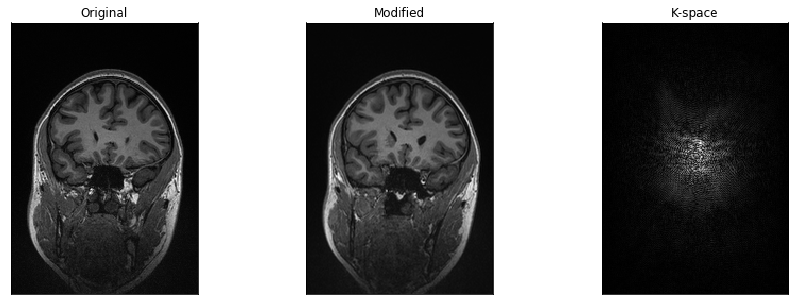

In [0]:
# testing out mod_kspace_slice
rot = [motion1.yaw[0], motion1.pitch[0], motion1.roll[0]]
trans = [motion1.trans_x[0], motion1.trans_y[0], motion1.trans_z[0]]
slice_num = 100
modded_k, modded_v = mri1.mod_kspace_slice(trans,rot,slice_num)
modded_k_vis = np.abs(modded_k)
plt.figure(figsize= (15,5))
plt.subplot(131), plt.imshow(img[slice_num], cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(modded_v, cmap='gray')
plt.title('Modified'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(modded_k_vis, cmap='gray')
plt.title('K-space'), plt.xticks([]), plt.yticks([])

Slice #0 out of 256 completed
Slice #3 out of 256 completed
Slice #6 out of 256 completed
Slice #9 out of 256 completed
Slice #12 out of 256 completed
Slice #15 out of 256 completed
Slice #18 out of 256 completed
Slice #21 out of 256 completed
Slice #24 out of 256 completed
Slice #27 out of 256 completed
Slice #30 out of 256 completed
Slice #33 out of 256 completed
Slice #36 out of 256 completed
Slice #39 out of 256 completed
Slice #42 out of 256 completed
Slice #45 out of 256 completed
Slice #48 out of 256 completed
Slice #51 out of 256 completed
Slice #54 out of 256 completed
Slice #57 out of 256 completed
Slice #60 out of 256 completed
Slice #63 out of 256 completed
Slice #66 out of 256 completed
Slice #69 out of 256 completed
Slice #72 out of 256 completed
Slice #75 out of 256 completed
Slice #78 out of 256 completed
Slice #81 out of 256 completed
Slice #84 out of 256 completed
Slice #87 out of 256 completed
Slice #90 out of 256 completed
Slice #93 out of 256 completed
Slice #96 ou

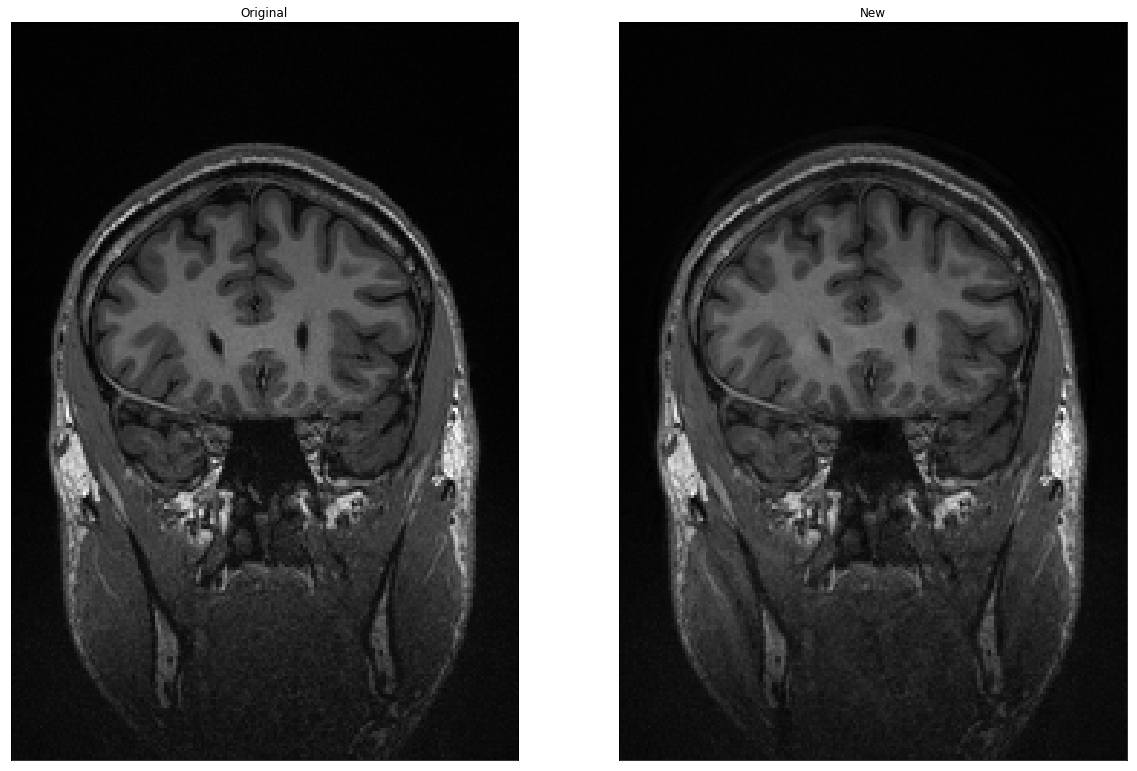

In [0]:
# Testing out pipeline for one file, translation with x1 scale

mri1 = mri('gdrive/My Drive/NU_Rad/mris/M02.nii')
motion1 = motion('gdrive/My Drive/NU_Rad/motion/motion5.dat')
transf_v, mod_v, mod_log = mri1.create_mod_slices(motion1)

mri1.show_slice(transf_v[100], 100, 'v')

In [0]:
# Read in saved kspace file

k_r = np.loadtxt('/content/gdrive/My Drive/mri1_kspace_r.txt.gz', delimiter=",")
k_i = np.loadtxt('/content/gdrive/My Drive/mri1_kspace_i.txt.gz', delimiter=",")
k_r = np.reshape(k_r,image_shape)
k_i = np.reshape(k_i,image_shape)

kspace = k_r + k_i*1j


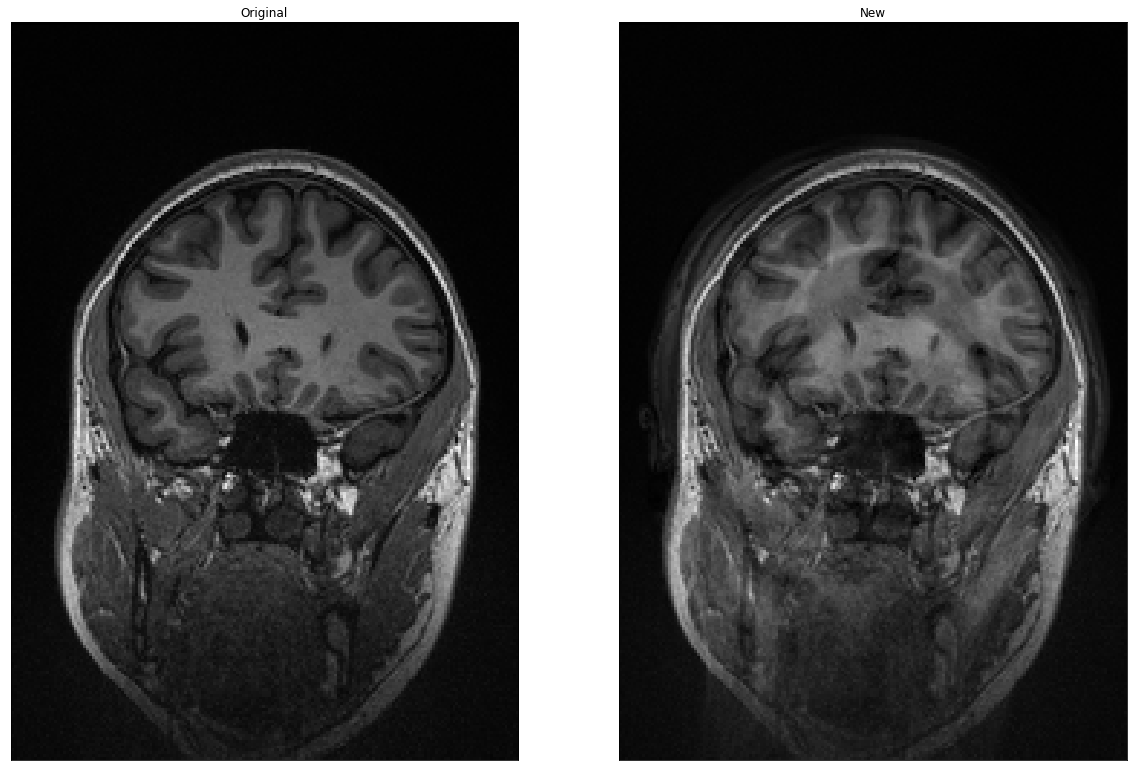

In [0]:
new_vis = mri1.fft_back(kspace)
mri1.save_to_file(new_vis, '/content/gdrive/My Drive/mri1_transf_v')
mri1.show_slice(np.abs(new_vis[100]), 100, 'v')

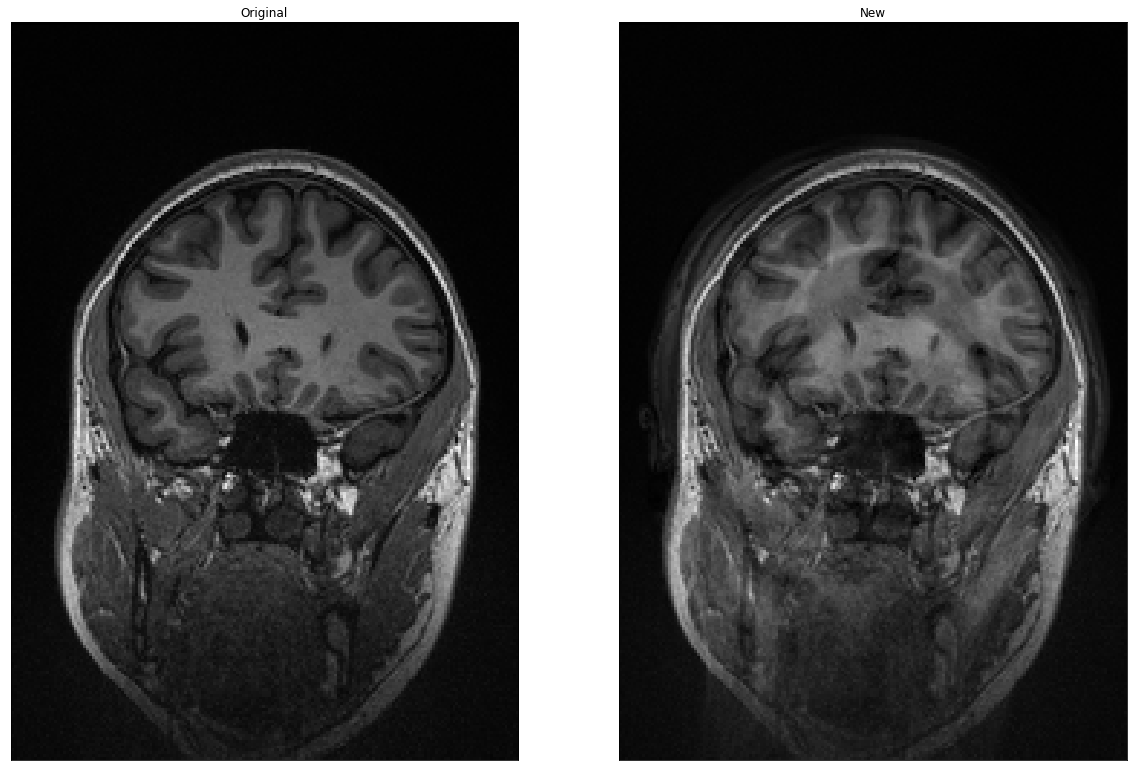

In [0]:
new_vis = mri1.fft_back(kspace)
mri1.save_to_file(new_vis, '/content/gdrive/My Drive/mri1_transf_v')
mri1.show_slice(np.abs(new_vis[100]), 100, 'v')


In [0]:
mod_r = np.loadtxt('/content/gdrive/My Drive/mri1_transf_v_r.txt.gz', delimiter=",")
mod_i = np.loadtxt('/content/gdrive/My Drive/mri1_transf_v_i.txt.gz', delimiter=",")
mod_r = np.reshape(mod_r,image_shape)
mod_i = np.reshape(mod_i,image_shape)
mod_full = np.abs(mod_r + mod_i*1j)

rot_r = np.loadtxt('/content/gdrive/My Drive/mri1_vspace_r.txt.gz', delimiter=",")
rot_i = np.loadtxt('/content/gdrive/My Drive/mri1_vspace_i.txt.gz', delimiter=",")
rot_r = np.reshape(rot_r,image_shape)
rot_i = np.reshape(rot_i,image_shape)
rot_full = np.abs(rot_r + rot_i*1j)

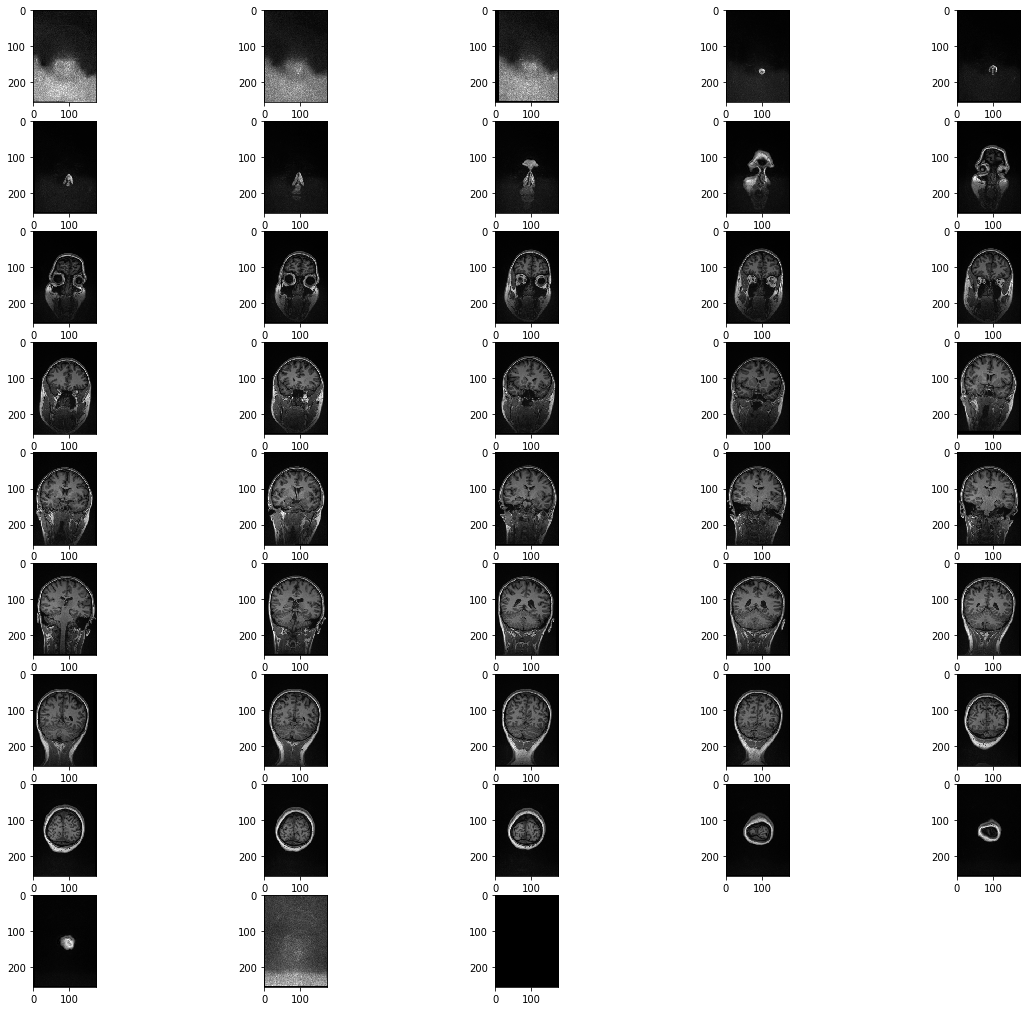

In [0]:
rot_full = np.abs(rot_r + rot_i*1j)
mri1.show_rotations(rot_full)

In [0]:
mri1 = mri('gdrive/My Drive/NU_Rad/mris/M01.nii')
motion1 = motion('gdrive/My Drive/NU_Rad/motion/motion1.dat')


In [0]:
transf_v, modded_v, trans_log = mri1.create_mod_slices(motion1)
modded_v = np.transpose(modded_v,(2,1,0))
transf_v = np.transpose(transf_v,(2,1,0))
mri1.save_to_file(transf_v, 'gdrive/My Drive/NU_Rad/cache/M01_motion1_transf.txt.gz')
mri1.show_rotations(transf_v)

Slice #0 out of 256 completed
Slice #1 out of 256 completed
Slice #2 out of 256 completed
Slice #3 out of 256 completed
Slice #4 out of 256 completed
Slice #5 out of 256 completed
Slice #6 out of 256 completed
Slice #7 out of 256 completed
Slice #8 out of 256 completed
Slice #9 out of 256 completed
Slice #10 out of 256 completed
Slice #11 out of 256 completed
Slice #12 out of 256 completed
Slice #13 out of 256 completed
Slice #14 out of 256 completed
Slice #15 out of 256 completed
Slice #16 out of 256 completed
Slice #17 out of 256 completed
Slice #18 out of 256 completed
Slice #19 out of 256 completed
Slice #20 out of 256 completed
Slice #21 out of 256 completed
Slice #22 out of 256 completed
Slice #23 out of 256 completed
Slice #24 out of 256 completed
Slice #25 out of 256 completed
Slice #26 out of 256 completed
Slice #27 out of 256 completed
Slice #28 out of 256 completed
Slice #29 out of 256 completed
Slice #30 out of 256 completed
Slice #31 out of 256 completed
Slice #32 out of 2

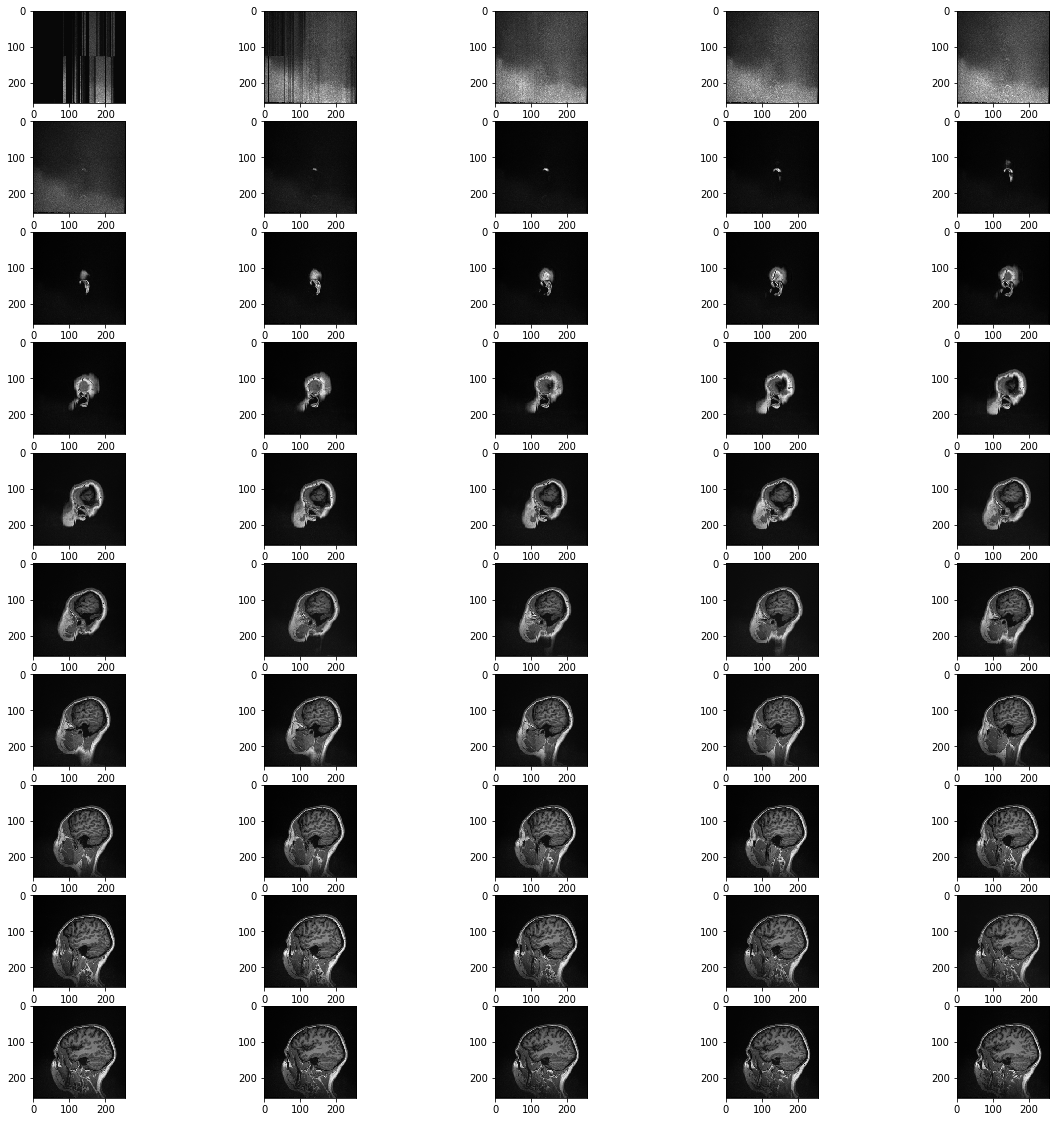

In [0]:
mri1.show_rotations(modded_v)

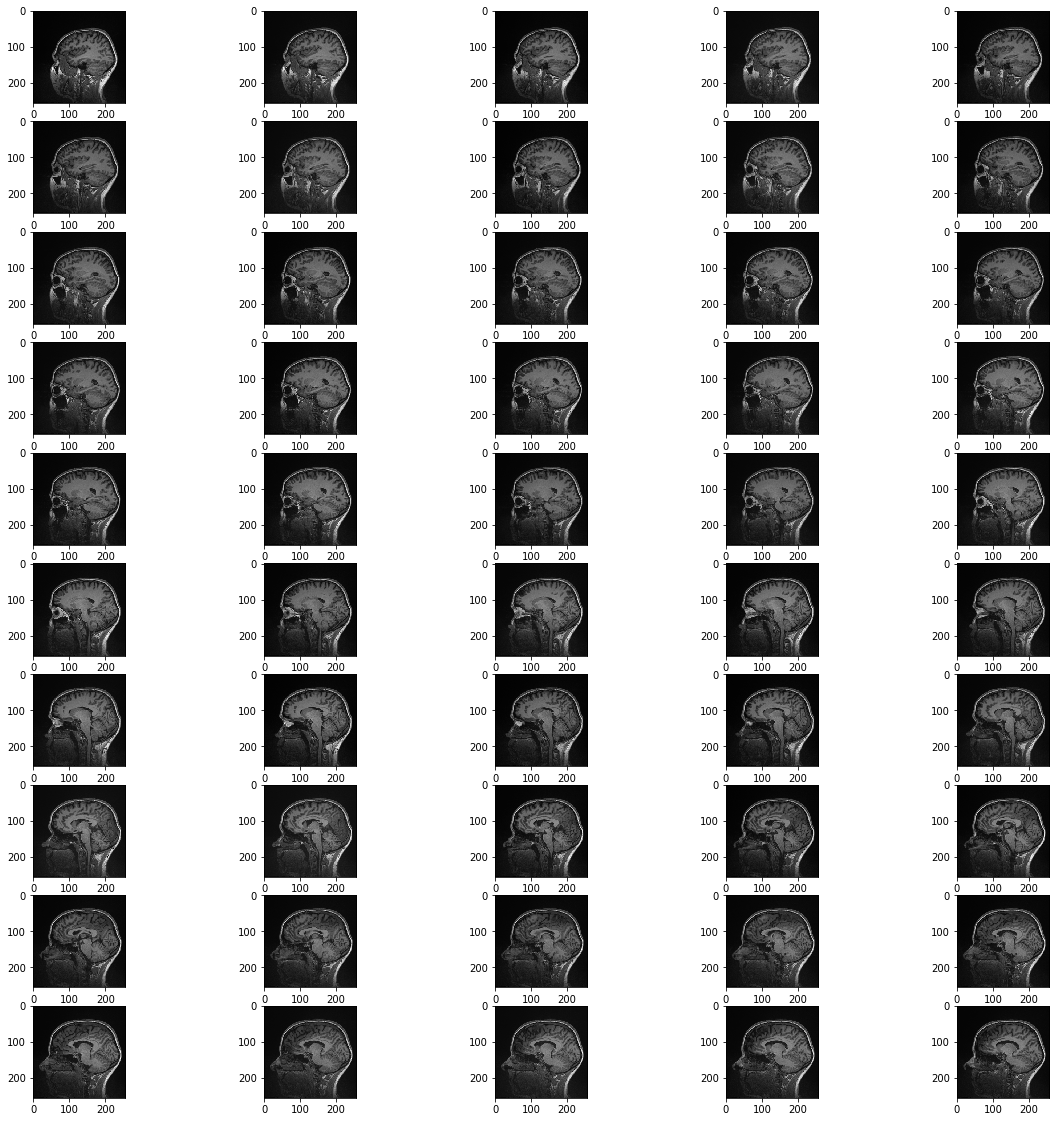

In [0]:
mri1.show_rotations(modded_v[50:])

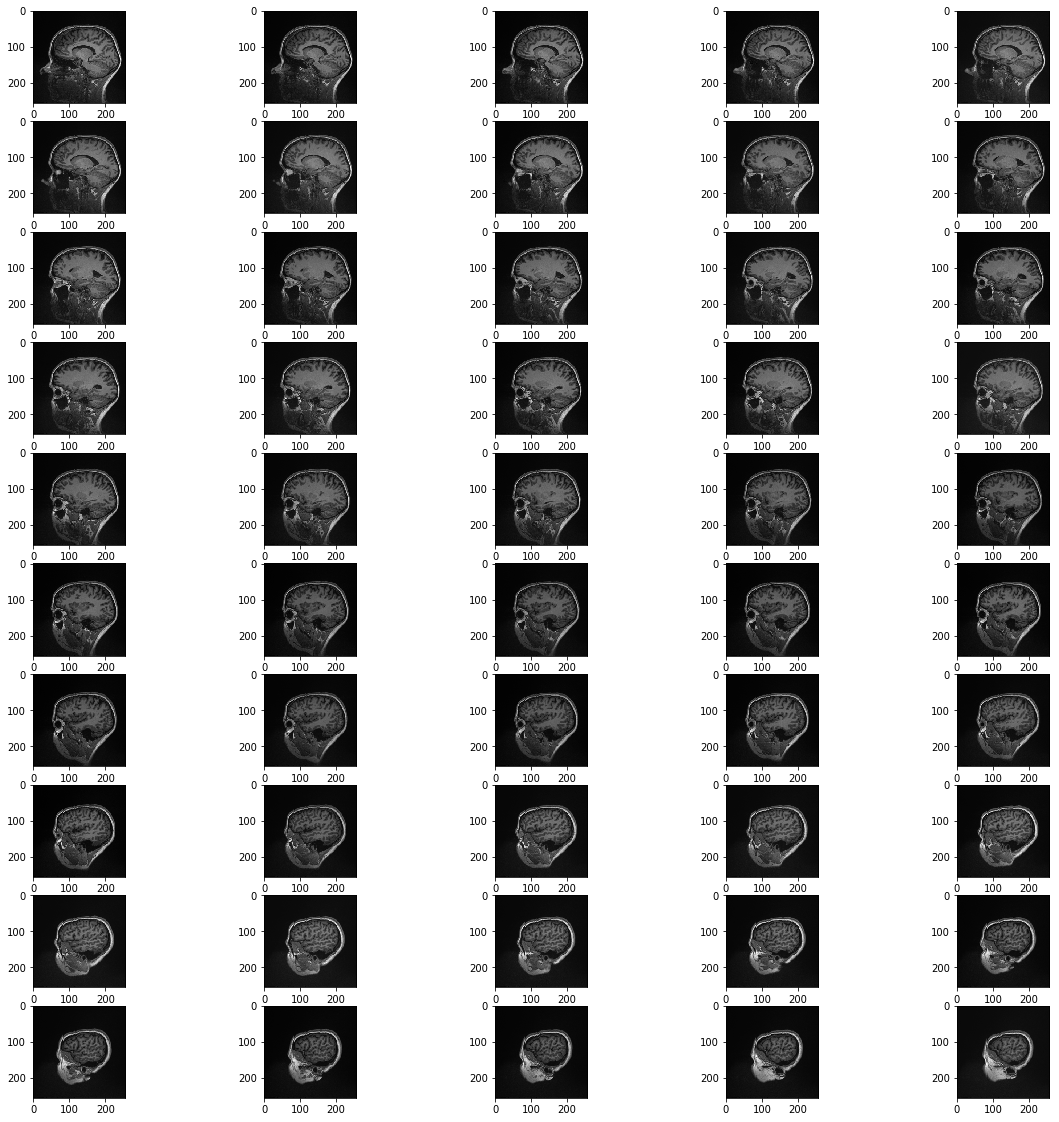

In [0]:
mri1.show_rotations(modded_v[100:])

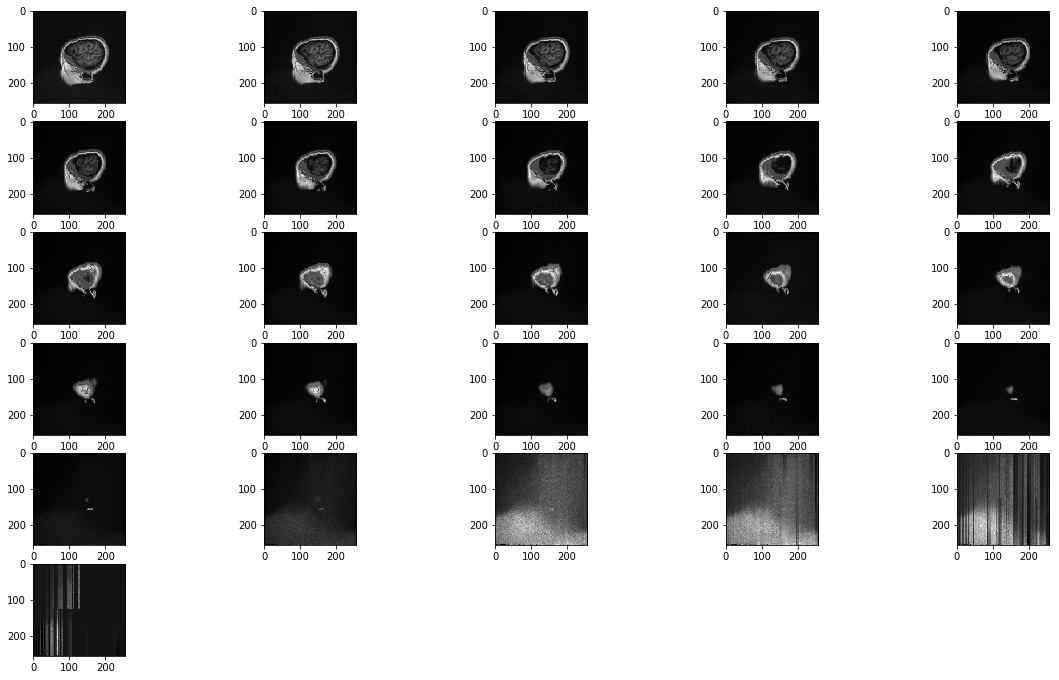

In [0]:
mri1.show_rotations(modded_v[150:])

In [0]:
transf_v.shape()

NameError: ignored

In [0]:
# To Do
# Processing images
#     Make it so it caches the 3d image as it goes, and then outputs a 3d visual
#     Naming scheme- mri#_v, mri#_rot (text file of which slice, and transformations)
# Model
#     Take in image of this size